## Imports

In [1]:
import copy
import pickle
import sys
import tempfile
import uuid
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

cpu = torch.device("cpu")

In [5]:
%load_ext autoreload
%autoreload 2

## Parameters

In [6]:
try:
    NOTEBOOK_PATH
    UNIQUE_PATH
except NameError:
    NOTEBOOK_PATH = Path("train_residual_tconv").resolve()
    NOTEBOOK_PATH.mkdir(exist_ok=True)
    unique_id = uuid.uuid4().hex[:8]
    UNIQUE_PATH = NOTEBOOK_PATH.joinpath(unique_id)
    UNIQUE_PATH.mkdir()
NOTEBOOK_PATH, UNIQUE_PATH

(PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_residual_tconv'),
 PosixPath('/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_residual_tconv/02c44a0f'))

In [7]:
device = torch.device("cuda:1")

## Workspace

In [8]:
!ls ../data/

data-training.csv.gz


### Load data

In [9]:
try:
    with Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name, "train_data_4.pkl").open("rb") as fin:
        TRAIN_TEST_SPLITS = pickle.load(fin)
except FileNotFoundError:
    %run prepare_training_data_4.ipynb
    temp_data_path = Path(tempfile.gettempdir()).joinpath(NOTEBOOK_PATH.name)
    temp_data_path.mkdir(exist_ok=True)
    with temp_data_path.joinpath("train_data_4.pkl").open("wb") as fout:
        pickle.dump(TRAIN_TEST_SPLITS, fout, pickle.HIGHEST_PROTOCOL)

In [10]:
train_df, valid_df = TRAIN_TEST_SPLITS[-1]

In [11]:
train_df.head()

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0 -0.172715 -0.169291 -0.162441 -0.162441 -0.162441 -0.162441 -0.162441   
1 -0.172715 -0.169291 -0.162441 -0.159017 -0.159017 -0.159017 -0.159017   
2 -0.172715 -0.169291 -0.162441 -0.159017 -0.155592 -0.155592 -0.155592   
3 -0.172715 -0.169291 -0.162441 -0.159017 -0.155592 -0.155592 -0.155592   
4 -0.172715 -0.169291 -0.162441 -0.159017 -0.155592 -0.155592 -0.155592   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0 -0.162441 -0.162441 -0.162441  -0.162441  -0.162441  -0.162441  -0.162441   
1 -0.159017 -0.159017 -0.159017  -0.159017  -0.159017  -0.159017  -0.159017   
2 -0.155592 -0.155592 -0.155592  -0.155592  -0.155592  -0.155592  -0.155592   
3 -0.155592 -0.155592 -0.155592  -0.155592  -0.155592  -0.155592  -0.155592   
4 -0.155592 -0.155592 -0.155592  -0.155592  -0.155592  -0.155592  -0.155592   

   askRate14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  bidRate5  \
0  -0.162441 -0.203537 -0.210386 -0.217236 -0.224085 -0.230934 -0.237784   
1  -0.159017 -0.203537 -0.210386 -0.217236 -0.224085 -0.230934 -0.237784   
2  -0.155592 -0.203537 -0.210386 -0.217236 -0.224085 -0.230934 -0.237784   
3  -0.155592 -0.203537 -0.210386 -0.217236 -0.224085 -0.230934 -0.237784   
4  -0.155592 -0.203537 -0.210386 -0.217236 -0.224085 -0.230934 -0.237784   

   bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  bidRate12  \
0 -0.258332 -0.265181  -0.27203  -0.27888  -0.285729  -0.292578  -0.296003   
1 -0.258332 -0.265181  -0.27203  -0.27888  -0.285729  -0.292578  -0.296003   
2 -0.258332 -0.265181  -0.27203  -0.27888  -0.285729  -0.292578  -0.296003   
3 -0.258332 -0.265181  -0.27203  -0.27888  -0.285729  -0.292578  -0.296003   
4 -0.258332 -0.265181  -0.27203  -0.27888  -0.285729  -0.292578  -0.296003   

   bidRate13  bidRate14  askSize0  askSize1  askSize2  askSize3  askSize4  \
0  -0.299428  -0.306277       0.0  0.353524  0.487938  0.000000  0.000000   
1  -0.299428  -0.306277       0.0  0.353524  0.487938  0.247103  0.000000   
2  -0.299428  -0.306277       0.0  0.353524  0.487938  0.247103  0.106421   
3  -0.299428  -0.306277       0.0  0.353524  0.487938  0.247103  0.474579   
4  -0.299428  -0.306277       0.0  0.353524  0.487938  0.247103  0.532107   

   askSize5  askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  \
0       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
1       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
2       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
3       0.0       0.0       0.0       0.0       0.0        0.0        0.0   
4       0.0       0.0       0.0       0.0       0.0        0.0        0.0   

   askSize12  askSize13  askSize14  bidSize0  bidSize1  bidSize2  bidSize3  \
0        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
1        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
2        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
3        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   
4        0.0        0.0        0.0  0.298763  0.353524       0.0  0.353524   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
1  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
2  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
3  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   
4  0.459946  0.168674  0.459946  0.506022  0.368158  0.405184   0.545866   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0   0.353524        0.0   0.353524   0.393806 -0.5  
1   0.353524        0.0   0.353524   0.393806 -0.5  
2   0.353524        0.0   0.353524   0.393806 -0.5  
3   0.353524        0.0   0.353524   0.393806 -0.5  
4   0.353524        0.0   0.353524

### Define model

In [67]:
%%file {UNIQUE_PATH}/model.py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    max_values = None

    def __init__(self, data, num_previous=1, mode="train") -> None:
        super().__init__()
        assert num_previous > 0
#         self.values = (
#             data[:, :-1].reshape(data.shape[0], 4, 15).transpose([1, 2, 0]).copy()
#         )
        self.values = data[:, :-1].copy()
        self.targets = data[:, -1:].copy()
        self.num_previous = num_previous
        self.mode = mode

    def __len__(self):
        if self.mode == "train":
            return self.targets.shape[0] // self.num_previous - 1
        else:
            return self.targets.shape[0] - self.num_previous + 1

    def __getitem__(self, index):
        if self.mode == "train":
            offset = np.random.randint(0, self.num_previous - 1)
            step = self.num_previous
        else:
            offset = 0
            step = 1

        start = offset + index * step
        stop = start + self.num_previous

#         values = self.values[:, :, start:stop]
        values = self.values[start:stop, :]
        targets = self.targets[start:stop, :]

        return values, targets


class XTXModel(nn.Module):
    def __init__(self, input_size, output_size, kernel_sizes, num_previous, dropout):
        super().__init__()
        self.num_previous = num_previous

        self.embed1 = nn.Sequential(
            #
            nn.Conv2d(4, 32, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv2d(32, 1, kernel_size=1, stride=1, padding=0),
        )
        self.embed2 = nn.Sequential(
            nn.Conv1d(15, 1, kernel_size=2, stride=1, padding=1)
        )
        self.embed3 = nn.Sequential(
            nn.Conv1d(60, 32, kernel_size=1, stride=1, padding=0),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(32, 32, kernel_size=2, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(32, 1, kernel_size=1, stride=1, padding=0),
        )

        hidden_size = 1

        self.layer1 = nn.Sequential(
            #
            nn.Conv1d(hidden_size, 10, kernel_size=181, stride=1, padding=90),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(10, hidden_size, kernel_size=3, stride=1, padding=1),
        )
        self.norm1 = nn.BatchNorm1d(hidden_size)

        self.layer2 = nn.Sequential(
            #
            nn.Conv1d(hidden_size, 10, kernel_size=1990, stride=1, padding=90),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(10, hidden_size, kernel_size=3, stride=1, padding=1),
        )
        self.norm2 = nn.BatchNorm1d(hidden_size)

        self.layer_out = nn.Sequential(
            nn.Conv1d(hidden_size, output_size, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x = x.transpose(1, 2)
        num_points = x.size(-1)
        x = self.embed3(x)
        x = x[:, :, :num_points]

#         x = self.embed1(x)
#         x = x.squeeze(1)
#         x = self.embed2(x)
        
        x_new = self.layer1(x)
        return x_new.transpose(1, 2)

        x_new = self.norm1(x_new)
        x = x + x_new

        x_new = self.layer2(x)
        x_new = self.norm2(x_new)
        x = x + x_new

        x = self.layer_out(x)

        x = x.transpose(1, 2)
        return x


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

Overwriting /home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/notebooks/train_residual_tconv/02c44a0f/model.py


In [68]:
%run {UNIQUE_PATH}/model.py

### Train model

In [69]:
batch_size = 600
num_previous = 1000
kernel_sizes = [100 + 81, 1]
dropout = 0.5

In [70]:
train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous, mode="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataset))

valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous, mode="train")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(valid_dataset))

2398
599


In [71]:
net = XTXModel(1, 1, kernel_sizes=kernel_sizes, num_previous=num_previous, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

In [72]:
num_back = 10 + 81
end_offset = sum(kz - 1 for kz in kernel_sizes) - num_back
start_offset = sum(kz - 1 for kz in kernel_sizes) - end_offset

zero_pad_start = torch.zeros(batch_size, max(0, start_offset), 1).to(device)
zero_pad_x = torch.zeros(batch_size, end_offset, 1).to(device)
zero_pad_end = torch.zeros(batch_size, end_offset, 1).to(device)

for epoch in range(200):
    net.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_in = x
        x_out = net(x_in)
        loss = criterion(x_out, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"{sum(train_losses) / len(train_losses):.4f}", end=" ")
    train_loss = sum(train_losses) / len(train_losses)

    if (epoch + 1) % 10 == 0:
        net.eval()
        valid_losses = []
        valid_mid_losses = []
        valid_start_losses = []
        valid_end_losses = []
        valid_last_losses = []
        valid_scores = []
        for i, batch in enumerate(valid_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            x_in = x
            with torch.no_grad():
                x_out = net(x_in)
            loss = criterion(x_out, y)
            loss_mid = criterion(
                x_out[:, end_offset:-end_offset], y[:, end_offset:-end_offset]
            )
            loss_start = criterion(x_out[:, :end_offset], y[:, :end_offset])
            loss_stop = criterion(x_out[:, -end_offset:], y[:, -end_offset:])
            loss_last = criterion(x_out[:, -1:], y[:, -1:])
            score = 1 - ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
            valid_losses.append(loss.item())
            valid_mid_losses.append(loss_mid.item())
            valid_start_losses.append(loss_start.item())
            valid_end_losses.append(loss_stop.item())
            valid_last_losses.append(loss_last.item())
            valid_scores.append(score)
        print(
            "    "
            f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_mid_losses) / len(valid_mid_losses):.4f} "
            f"{sum(valid_start_losses) / len(valid_start_losses):.4f} {sum(valid_end_losses) / len(valid_end_losses):.4f} "
            f"{sum(valid_last_losses) / len(valid_last_losses):.4f} {sum(valid_scores) / len(valid_scores):.4f}"
        )

0.5429 0.5390 0.5380 0.5484 0.5413 0.5372 0.5375 0.5400 0.5407 0.5361     0.3672 0.3643 0.3869 0.3740 0.3171 -0.0001
0.5469 0.5359 0.5395 0.5365 0.5424 0.5372 0.5451 0.5393 0.5336 0.5413     0.3671 0.3643 0.3869 0.3739 0.3171 -0.0000
0.5364 0.5396 0.5361 0.5383 0.5358 0.5404 0.5389 0.5376 0.5341 0.5344     0.3672 0.3643 0.3869 0.3740 0.3171 -0.0000
0.5370 0.5382 0.5351 0.5386 0.5328 0.5461 0.5366 0.5444 0.5385 0.5364     0.3673 0.3644 0.3870 0.3740 0.3171 -0.0001
0.5402 0.5331 0.5407 0.5363 0.5352 0.5407 0.5422 0.5335 0.5392 0.5353     0.3671 0.3642 0.3868 0.3739 0.3171 0.0001
0.5322 0.5329 0.5318 0.5387 0.5295 0.5304 0.5263 0.5312 0.5174 0.5034     0.3241 0.3140 0.3397 0.4016 0.3252 -0.0257
0.4993 0.4946 0.4925 0.4863 0.4738 0.4802 0.4719 0.4660 0.4706 0.4617     0.2982 0.2803 0.3127 0.4481 0.3273 -0.0321
0.4570 0.4554 0.4590 0.4551 0.4520 0.4493 0.4531 0.4523 0.4523 0.4456     0.2891 0.2668 0.2952 0.4881 0.3469 -0.0940
0.4467 0.4426 0.4478 0.4442 0.4437 0.4464 0.4532 0.4397 0.4475 0.

In [42]:
# 0.0026 (0.2525) min = 0.0033
0.0083

0.0083

In [85]:
x.shape

torch.Size([600, 2, 30, 500])

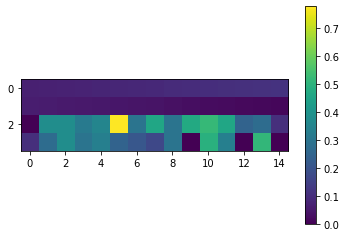

In [21]:
plt.imshow(x[20, :, :, 0].to(cpu).data.numpy())
plt.colorbar()

In [72]:
y.shape

torch.Size([600, 500, 1])

In [ ]:
net.eval()
for param in net.layer1.parameters():
    param.requires_grad = False

In [ ]:
batch_size = 100
num_previous = 500

train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous, mode="train")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataset))

valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous, mode="valid")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(valid_dataset))

In [ ]:
cpu = torch.device("cpu")

In [ ]:
num_back = 10
end_offset = sum(kz - 1 for kz in kernel_sizes) - num_back
start_offset = sum(kz - 1 for kz in kernel_sizes) - end_offset

zero_pad_start = torch.zeros(batch_size, max(0, start_offset), 1).to(device)
zero_pad_x = torch.zeros(batch_size, end_offset, 1).to(device)
zero_pad_end = torch.zeros(batch_size, end_offset, 1).to(device)

for epoch in range(200):
    net.train()
    train_losses = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_in = torch.cat(
            [
                zero_pad_start[: x.size(0), :, :],
                zero_pad_x[: x.size(0), :, :],
                x[:, zero_pad_x.size(1) :, :],
                zero_pad_end[: x.size(0), :, :],
            ],
            1,
        )
        x_out = net(x_in)
        loss = criterion(x_out[:, -1, :], y[:, -1, :])
#         loss = ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"{sum(train_losses) / len(train_losses):.4f}", end=" ")
    train_loss = sum(train_losses) / len(train_losses)

    valid_ys = []
    valid_x_outs = []
    if (epoch + 1) % 1 == 0:
        net.eval()
        valid_losses = []
        valid_mid_losses = []
        valid_start_losses = []
        valid_end_losses = []
        valid_scores = []
        for i, batch in enumerate(valid_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            x_in = torch.cat(
                [
                    zero_pad_start[: x.size(0), :, :],
                    zero_pad_x[: x.size(0), :, :],
                    x[:, zero_pad_x.size(1) :, :],
                    zero_pad_end[: x.size(0), :, :],
                ],
                1,
            )
            with torch.no_grad():
                x_out = net(x_in)
            loss = criterion(x_out, y)
            loss_mid = criterion(
                x_out[:, end_offset:-end_offset], y[:, end_offset:-end_offset]
            )
            loss_start = criterion(x_out[:, :end_offset], y[:, :end_offset])
            loss_stop = criterion(x_out[:, -end_offset:], y[:, -end_offset:])
            valid_losses.append(loss.item())
            valid_mid_losses.append(loss_mid.item())
            valid_start_losses.append(loss_start.item())
            valid_end_losses.append(loss_stop.item())
            valid_scores.append(score)
            valid_ys.append(y[:, -1, 0].squeeze().to(cpu).data.numpy())
            valid_x_outs.append(x_out[:, -1, 0].squeeze().to(cpu).data.numpy())
        valid_y = np.hstack(valid_ys)
        valid_x_out = np.hstack(valid_x_outs)
        valid_score = 1 - ((valid_y - valid_x_out) ** 2).sum() / (valid_y ** 2).sum()
        print(
            "    "
            f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_mid_losses) / len(valid_mid_losses):.4f} "
            f"{sum(valid_start_losses) / len(valid_start_losses):.4f} {sum(valid_end_losses) / len(valid_end_losses):.4f} "
            f"{valid_score:.4f}"
        )

In [ ]:
zero_pad_start.shape

In [ ]:
train_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous=600000, mode="valid")

In [ ]:
valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous=600000, mode="valid")

In [ ]:
len(valid_dataset)

In [ ]:
x, y = valid_dataset[0]
x = torch.from_numpy(x).to(device).unsqueeze(0)
y = torch.from_numpy(y).to(device).unsqueeze(0)

In [ ]:
x_in = torch.cat(
    [zero_pad_start[: x.size(0), :, :], x, zero_pad_end[: x.size(0), :, :]], 1
)
x_out = net(x_in)

In [ ]:
cpu = torch.device("cpu")

In [ ]:
pred = np.cumsum(x_out.squeeze().to(cpu).data.numpy())
actual = np.cumsum(y.squeeze().to(cpu).data.numpy())
plt.plot(pred)
plt.plot(actual)

In [ ]:
stats = []
for i in range(0, len(pred)):
    

In [ ]:
len(pred)

In [ ]:
len(actual)

In [ ]:
from scipy import stats

In [ ]:
stats.pearsonr(pred, actual[1:len(pred) + 1])

In [ ]:
(0.9999665754240266, 0.0)


In [ ]:
b.shape

In [ ]:
batch_size = 20000
kernel_sizes = [30, 3]
num_previous = 300

train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous, mode="valid")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(len(train_dataset))

valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous, mode="valid")
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
print(len(valid_dataset))

In [ ]:
net2 = XTXModel(2, 1, kernel_sizes=kernel_sizes, num_previous=num_previous, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(net2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

In [ ]:
history_offset = 90
zero_pad_history = torch.zeros(batch_size, history_offset, 1).to(device)

zero_pad_x2 = torch.zeros(batch_size, sum(kz - 1 for kz in kernel_sizes), 2).to(device)

num_back = 10
end_offset = sum(kz - 1 for kz in kernel_sizes) - num_back
start_offset = sum(kz - 1 for kz in kernel_sizes) - end_offset

zero_pad_start = torch.zeros(batch_size, max(0, start_offset), 1).to(device)
zero_pad_x = torch.zeros(batch_size, end_offset, 1).to(device)
zero_pad_end = torch.zeros(batch_size, end_offset, 1).to(device)

for epoch in range(200):
    net2.train()
    train_losses = []
    train_scores = []
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        # Net 1
        x_in = torch.cat([x, zero_pad_end[: x.size(0), :, :]], 1)
        x_out = net(x_in)
        x_out = x_out[:, :-history_offset, :]

        # Net 2
        optimizer.zero_grad()
        x_in = torch.cat([x_out, x[:, -x_out.size(1) :, :]], dim=2)
        x_out = net2(x_in)
        #         loss = criterion(x_out, y)
        loss = ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        score = 1 - ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum() / (y[:, -1, :] ** 2).sum()
        train_scores.append(score.item())

    print(f"{sum(train_losses) / len(train_losses):.4f}", end=" ")
    train_loss = sum(train_losses) / len(train_losses)

    if (epoch + 1) % 1 == 0:
        net2.eval()
        valid_losses = []
        valid_scores = []
        valid_mid_losses = []
        valid_start_losses = []
        valid_end_losses = []
        for i, batch in enumerate(valid_loader):
            x, y = batch
            x = x.to(device)
            y = y.to(device)

            # Net 1
            x_in = torch.cat([x, zero_pad_end[: x.size(0), :, :]], 1)
            x_out = net(x_in)
            x_out = x_out[:, :-history_offset, :]

            # Net 2
            x_in = torch.cat([x_out, x[:, -x_out.size(1) :, :]], dim=2)
            with torch.no_grad():
                x_out = net2(x_in)
            loss = criterion(x_out[:, -1, :], y[:, -1, :])
            valid_losses.append(loss.item())

            score = (
                1
                - ((y[:, -1, :] - x_out[:, -1, :]) ** 2).sum()
                / (y[:, -1, :] ** 2).sum()
            )
            valid_scores.append(score.item())

        print(
            "    "
            f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_scores) / len(valid_scores):.4f}"
            #             f"{sum(valid_losses) / len(valid_losses):.4f} {sum(valid_mid_losses) / len(valid_mid_losses):.4f} "
            #             f"{sum(valid_start_losses) / len(valid_start_losses):.4f} {sum(valid_end_losses) / len(valid_end_losses):.4f}"
        )

In [ ]:
x.shape

In [ ]:
zero_pad_end.shape

In [ ]:
90
0.5127 0.5103 0.5083 0.5066 0.5077 0.5062 0.5027 0.5022 0.4994 0.4957     0.5589 0.5580 0.5448 0.5812
0.4922 0.4865 0.4820 0.4733 0.4643 0.4511 0.4366 0.4231 0.4061 0.3851     0.4124 0.4043 0.3946 0.5032
0.3652 0.3440 0.3255 0.3023 0.2801 0.2610 0.2444 0.2302 0.2185 0.2121     0.1511 0.1275 0.1237 0.3899
0.2077 0.2073 0.2050 0.2028 0.2030 0.2010 0.1997 0.1971 0.1960 0.1952     0.1291 0.1039 0.1002 0.3840
0.1942 0.1925 0.1923 0.1900 0.1900 0.1890 0.1879 0.1877 0.1858 0.1840     0.1233 0.0977 0.0942 0.3819
0.1847 0.1834 0.1817 0.1810 0.1803 0.1792 0.1785 0.1757 0.1765 0.1759     0.1148 0.0886 0.0855 0.3797
0.1742 0.1724 0.1701 0.1710 0.1699 0.1680 0.1677 0.1672 0.1646 0.1652     0.1007 0.0733 0.0708 0.3761
0.1644 0.1648 0.1630 0.1617 0.1622 0.1629 0.1610 0.1613 0.1603 0.1603     0.0888 0.0604 0.0585 0.3739
0.1609 0.1591 0.1598 0.1593 0.1602 0.1589 0.1589 0.1595 0.1591 0.1587     0.0820 0.0530 0.0514 0.3725
0.1588 0.1583 0.1583 0.1589 0.1574 0.1580 0.1574 0.1584 0.1569 0.1582     0.0799 0.0508 0.0492 0.3720
0.1576 0.1572 0.1574 0.1575 0.1581 0.1574 0.1576 0.1583 0.1568 0.1582     0.0797 0.0505 0.0490 0.3719
0.1580 0.1568 0.1577 0.1577 0.1566 0.1570 0.1585 0.1565 0.1557 0.1574     0.0794 0.0503 0.0488 0.3718
0.1570 0.1563 0.1576 0.1568 0.1562 0.1573 0.1566 0.1578 0.1575 0.1563     0.0793 0.0501 0.0486 0.3717
0.1564 0.1573 0.1567 0.1569 0.1562 0.1562 0.1575 0.1558 0.1565 0.1571     0.0791 0.0500 0.0485 0.3716
0.1564 0.1556 0.1572 0.1568 0.1564 0.1561 0.1577 0.1567 0.1557 0.1572     0.0790 0.0498 0.0483 0.3715
0.1563 0.1570 0.1575 0.1564 0.1571 0.1566 0.1558 0.1558 0.1563 0.1556     0.0789 0.0497 0.0483 0.3715
0.1565 0.1564 0.1559 0.1555 0.1558 0.1568 0.1576 0.1572 0.1569 0.1558     0.0789 0.0498 0.0483 0.3715
0.1557 0.1559 0.1558 0.1560 0.1572 0.1562 0.1565 0.1563 0.1558 0.1580     0.0787 0.0496 0.0481 0.3714
0.1567 0.1563 0.1556 0.1563 0.1553 0.1560 0.1561 0.1562 0.1562 0.1561     0.0789 0.0497 0.0482 0.3714
0.1572 0.1566 0.1568 0.1558 0.1570 0.1560 0.1562 0.1570 0.1558 0.1556     0.0790 0.0499 0.0484 0.3714

In [ ]:
0.5261 0.5263 0.5224 0.5191 0.5187 0.5169 0.5113 0.5098 0.5056 0.5071     0.5790 0.5808
0.5029 0.4981 0.4970 0.4882 0.4822 0.4769 0.4678 0.4570 0.4472 0.4335     0.4907 0.4879
0.4173 0.4030 0.3880 0.3657 0.3492 0.3267 0.3054 0.2852 0.2649 0.2453     0.2570 0.2407
0.2296 0.2146 0.2046 0.1961 0.1899 0.1863 0.1821 0.1783 0.1756 0.1738     0.1366 0.1122
0.1703 0.1682 0.1664 0.1648 0.1624 0.1614 0.1584 0.1569 0.1551 0.1542     0.1348 0.1103
0.1520 0.1525 0.1496 0.1476 0.1478 0.1460 0.1445 0.1426 0.1410 0.1402     0.1240 0.0987
0.1380 0.1371 0.1366 0.1347 0.1332 0.1321 0.1315 0.1295 0.1293 0.1276     0.1079 0.0815
0.1264 0.1259 0.1248 0.1238 0.1236 0.1231 0.1223 0.1215 0.1210 0.1209     0.0935 0.0660
0.1206 0.1197 0.1192 0.1193 0.1184 0.1184 0.1184 0.1186 0.1182 0.1174     0.0852 0.0570
0.1176 0.1174 0.1173 0.1174 0.1173 0.1164 0.1170 0.1171 0.1169 0.1163     0.0821 0.0538

In [ ]:
cpu = torch.device("cpu")

In [ ]:
plt.plot(np.cumsum(x[0, :, 0].squeeze().to(cpu).data.numpy()))

In [ ]:
plt.plot(x[0, :, 0].squeeze().to(cpu).data.numpy())

In [ ]:
y_cumsum = np.cumsum(y[0, :, 0].squeeze().to(cpu).data.numpy())
pred_cumsum = np.cumsum(x_out[0, :, 0].squeeze().to(cpu).data.numpy())

# pred_cumsum = pred_cumsum / (pred_cumsum.max() - pred_cumsum.min()) * (y_cumsum.max() - y_cumsum.min()) 

plt.plot(pred_cumsum)
plt.plot(y_cumsum)

In [ ]:
x.shape

In [ ]:
    net.eval()
    random_gen.manual_seed(42)
    val_losses = []
    val_losses2 = []
    for i, batch in enumerate(valid_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            x_out = net(x_in)
        loss = criterion(x_out, y[: x_out.size(0), :])
        val_losses.append(loss.item())
    val_loss = sum(val_losses) / len(val_losses)
    balanced_loss = 0.4 * val_loss + 0.4 * val_loss2 + 0.2 * train_loss

    print(
        f"Train: {train_loss:.6f}, Valid: {val_loss:.6f}, Valid 2: {val_loss2:.6f}, Balanced: {balanced_loss:.6f}"
    )
    if balanced_loss > max_balanced_loss:
        break
    else:
        max_balanced_loss = balanced_loss

In [ ]:
batch_size = 256
num_previous = 1000
kernel_size = 100
dropout = 0.5

while True:
    unique_id = str(uuid.uuid4())
    unique_path = NOTEBOOK_PATH.joinpath(unique_id)
    try:
        unique_path.mkdir()
        break
    except FileExistsError:
        continue
print(f"Unique id: '{unique_id}'\n")

max_weighted_scores = []
for split_index, (train_df, valid_df) in enumerate(TRAIN_TEST_SPLITS):
    print(f"Split: {split_index}")

    train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    valid_dataset = XTXDataset(valid_df.astype(np.float32).values, num_previous)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    max_weighted_score = 0
    for repeat_index in range(3):
        print(f"Repeat: {repeat_index}")
        net = XTXModel(dropout=dropout, num_previous=num_previous).to(device)
        criterion = nn.MSELoss(reduction="sum")
        optimizer = optim.AdamW(net.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6], gamma=0.1)

        noise_x = torch.zeros(batch_size, 4, 15, num_previous).to(device)
        noise_y = torch.zeros(batch_size, 1).to(device)
        for epoch in range(10):
            print(f"Epoch: {epoch}")
            train_dataset = XTXDataset(train_df.astype(np.float32).values, num_previous)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

            net.train()

            scores = []
            for i, batch in enumerate(train_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                optimizer.zero_grad()
        #         noise_x.normal_(0, 0.1)
                out = net(x + noise_x[:x.size(0), :, :, :])
        #         noise_y.normal_(0, 0.1)
                loss = criterion(out, y[:, 0] + noise_y[:y.size(0), :])
                loss.backward()
                optimizer.step()

                if i % 500 == 0:
                    last_ys = y[:, 0].squeeze()
                    last_outs = out.squeeze()
                    score = (
                        1 - ((last_ys - last_outs) ** 2).sum() / (last_ys ** 2).sum()
                    ).item()
                    print(f"{score:.6f}", end=" ")
                    scores.append((i, score))
            scheduler.step()

            net.eval()
            y_list = []
            out_list = []
            for i, batch in enumerate(valid_loader):
                x, y = batch
                x = x.to(device)
                y = y.to(device)

                with torch.no_grad():
                    out = net(x)

                last_ys = y[:, 0].squeeze().to(torch.device("cpu")).data.numpy()
                last_outs = out.squeeze().to(torch.device("cpu")).data.numpy()
                y_list.append(last_ys)
                out_list.append(last_outs)

            last_ys = np.hstack(y_list)
            last_outs = np.hstack(out_list)
            score = (
                1 - ((last_outs - last_ys) ** 2).sum() / (last_ys ** 2).sum()
            ).item()
            print(f"Validation: {score:.6f}")
            
            weighted_score = (score + max(sum([s[1] for s in scores]) / len(scores), 0.04) / 4) / 2  # Need average increase of 0.02 to justify decrease of 0.005
            if weighted_score > max_weighted_score:
                max_weighted_score = weighted_score
                torch.save(net.state_dict(), unique_path.joinpath(f"model_{split_index}.pt"))

    print(f"Best weighted score for split {split_index}: {max_weighted_score:.6f}\n")
    max_weighted_scores.append(max_weighted_score)
    
print(f"Average best validation score: {sum(max_weighted_scores) / len(max_weighted_scores):.6f}")

In [ ]:
unique_id